# Vision

> Utils for images and videos.

In [ ]:
#| default_exp vision

In [ ]:
#| hide

from nbdev.showdoc import *
from fastcore.test import *

%nbdev_skip_test
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

UsageError: Line magic function `%nbdev_skip_test` not found.


In [ ]:
#| export

from dreamai.imports import *
from dreamai.core import *

/home/hamza/anaconda3/envs/dai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export

image_extensions = {'.art','.bmp','.cdr','.cdt','.cpt','.cr2','.crw','.djv','.djvu','.erf','.gif','.ico',
                    '.ief','.jng','.jp2','.jpe','.jpeg','.jpf','.jpg','.jpg2','.jpm','.jpx','.nef','.orf',
                    '.pat','.pbm','.pcx','.pgm','.png','.pnm','.ppm','.psd','.ras','.rgb','.svg','.svgz',
                    '.tif','.tiff','.wbmp','.xbm','.xpm','.xwd','.webp'}

def remove_images(images_path, final_count=0, fn=lambda x:True):
    imgs = get_image_files(images_path)
    remove = max(0, len(imgs) - final_count)
    removed = 0
    for i in imgs:
        if removed >= remove:
            break
        if fn(i):
            os.remove(i)
            removed+=1

def bgr2rgb(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def rgb2bgr(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

def gray2rgb(img):
    return cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

def rgb2gray(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def rgb2rgba(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2RGBA)

def bgra2rgb(img):
    if len(img.shape) > 2 and img.shape[2] == 4:
        return cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

def rgba2rgb(img):
    if len(img.shape) > 2 and img.shape[2] == 4:
        return cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

def rgb_read(img, shape=None):
    if not path_or_str(img):
        return img
    img = bgr2rgb(cv2.imread(str(img)))
    if shape is not None:
        img = cv2.resize(img, (shape[1], shape[0]))
    return img

def c1_read(img):
    "Read an image from `img` and convert it to grayscale."
    return cv2.imread(str(img), 0)

def tensor_to_img(t):
    if t.dim() > 3:
        return [np.array(np.transpose(t_,(1,2,0))) for t_ in t]
    return np.array(np.transpose(t,(1,2,0)))

def plt_show(im, cmap=None, title='', figsize=(7,7)):
    if path_or_str(im):
        im = rgb_read(im)
    # if is_tensor(im):
        # im = tensor_to_img(im)
        # if is_list(im): im = im[0]
    fig=plt.figure(figsize=figsize)
    plt.imshow(im, cmap=cmap)
    plt.title(title)
    plt.show()

def show_img(img, cmap=None, title='', figsize=(7,7)):
    if not is_list(img):
        imgs = [img]
    else:
        imgs = img
    [plt_show(img, cmap=cmap, title=title, figsize=figsize) for img in imgs]

def get_hw(x):
    "Return the height and width of `x`."
    if is_clip(x):
        return x.size[1], x.size[0]
    return np.array(x).shape[:2]

def get_image_files(path, recurse=True, folders=None,
                    map_fn=None, # A function to apply to each item.
                    sort_key=None, # A function to sort the items by.
                    reverse=False, shuffle=False):
    "Get image files in `path` recursively, only in `folders`, if specified."
    l = get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
    if sort_key is not None:
        l = sorted(l, key=sort_key)
    if reverse:
        l = list(l)[::-1]
    if shuffle:
        random.shuffle(l)
    if map_fn is not None:
        return list_map(l, map_fn)
    return l

def to_pil(x):
    if is_array(x):
        return Image.fromarray(x)
    return x

def add_alpha(img, alpha=None):
    "Add an alpha channel to `img`."
    if alpha is None:
        alpha = 255
    img = to_pil(img)
    img.putalpha(alpha)
    return np.array(img)

def has_alpha(img):
    return np.array(img).shape[-1] == 4

def color_to_rgb(color):
    "Convert str `color` to RGB."
    if type(color) == str:
        return list_map(np.ceil(colors.to_rgb(color)).astype(int)*255, int)
    return list_map(color, int)

def solid_color_img(shape=(300,300,3), color='black', alpha=None):
    if len(shape) < 3:
        shape = tuple(shape) + (3,)
    image = np.zeros(shape, np.uint8)
    color = color_to_rgb(color)
    image[:] = color[:3]
    if len(color) == 4:
        alpha = color[3]
    if alpha is not None:
        image = Image.fromarray(image)
        image.putalpha(alpha)
        image = np.array(image)
    return image

def solid_color_img_like(img, color='black', alpha=None):
    h,w = np.array(img).shape[:2]
    shape = (h,w,3)
    return solid_color_img(shape=shape, color=color, alpha=alpha)

def get_pos_factors(pos):
    pos_dict = {'center':0.5, 'left':0.15, 'right':0.85, 'top':0.15, 'bottom':0.85}
    x_factor, y_factor = [pos_dict.get(p,p) for p in pos]
    return x_factor, y_factor

def get_pos_(bh, bw, h, w, x_factor, y_factor):
    x = int((bw - w) * x_factor)
    y = int((bh - h) * y_factor)
    return x,y

def get_pos(img, bg,
            pos=('center', 'center'), # int for exact position, float for relative position, or str for position in ['center', 'left', 'right', 'top', 'bottom']
            relative=True):
    "Get the position (x,y) of `img` on `bg` with `pos` as reference."
    p0,p1 = copy.deepcopy(pos)
    if is_int(p0) and is_int(p1):
        relative = False
    if not relative:
        return pos
    x_factor, y_factor = get_pos_factors(pos)
    bg = np.array(bg)
    img = np.array(img)
    bh,bw = bg.shape[:2]
    try:
        h,w = img.shape[:2]
    except:
        h,w = img[:2]
    x,y = get_pos_(bh, bw, h, w, x_factor, y_factor)
    if is_int(p0):
        x = p0
    if is_int(p1):
        y = p1
        # print(x, y)
    return x,y

def paste_img(img, bg, pos=('center', 'center'), relative=True):
    "Paste `img` on `bg` at `pos`."
    bg = np.array(copy.deepcopy(bg))
    img = np.array(copy.deepcopy(img))
    if bg.shape[-1] != 4:
        bg = add_alpha(bg)
    if img.shape[-1] != 4:
        img = add_alpha(img)
    h,w = img.shape[:2]
    bgh, bgw = bg.shape[:2]
    x,y = get_pos(img, bg, pos, relative=relative)
    
    r1,r2 = y,y+h
    c1,c2 = x,x+w
   
    if x < 0 or y < 0 or x >= bgw or y >= bgh:
        # print(x,y,h,w,bgh,bgw)
        bgh2 = max(bgh,h)
        bgw = max(bgw,w)
        px, py = 0.,0.
        if x < 0:
            bgw2 = bgw + abs(x)
            x = 0
            px = 1.
        elif x >= bgw:
            bgw2 = x+w
        else:
            bgw2 = bgw
        if y < 0:
            bgh2 = bgh + abs(y)
            y = 0
            py = 1.
        elif y >= bgh:
            bgh2 = y+h
        else:
            bgh2 = bgh
        new_bg = solid_color_img((bgh2, bgw2, 3), alpha=0)
        bg = paste_img(bg, new_bg, pos=(px,py))
        bgh, bgw = bg.shape[:2]
        r1,r2 = y,y+h
        c1,c2 = x,x+w
    
    elif h>bgh and w>bgw:
        hf = (h-bgh)//2
        wf = (w-bgw)//2
        img = img[hf:hf+bgh, wf:wf+bgw]
        r1,r2 = 0,bgh
        c1,c2 = 0,bgw
    elif h>bgh:
        hf = (h-bgh)//2
        img = img[hf:hf+bgh]
        r1,r2 = 0,bgh
    elif w>bgw:
        wf = (w-bgw)//2
        img = img[:,wf:wf+bgw]
        c1,c2 = 0,bgw

    bg2 = copy.deepcopy(bg[r1:r2, c1:c2])
    bg2h, bg2w = get_hw(bg2)
    img = img[:bg2h, :bg2w]
    # print(bg.shape, bg2.shape, img.shape, r2-r1, c2-c1)
    bgh, bgw = bg2.shape[:2]
    bg_rgb = bg2[...,:3]
    img_rgb = img[...,:3]
    bg_alpha = bg2[...,3]/255.0
    img_alpha = img[...,3]/255.0
    # print(img_alpha.shape)
    if (bg_alpha == 1).all():
        bg_alpha = 1-img_alpha
    i_len = len(img_alpha)
    for i in range(i_len):
        j_len = len(img_alpha[i])
        for j in range(j_len):
            if img_alpha[i][j] == 1:
                # try:
                bg_alpha[i][j] = 0
                # except:
                    # pass
    out_alpha = bg_alpha + img_alpha*(1-bg_alpha)
    out_rgb = (bg_rgb*bg_alpha[...,np.newaxis] + img_rgb*img_alpha[...,np.newaxis]*(1-bg_alpha[...,np.newaxis])) / out_alpha[...,np.newaxis]
    out_rgba = np.dstack((out_rgb,out_alpha*255)).astype(np.uint8)
    bg[r1:r2,c1:c2] = out_rgba
    return bg

## Some usage examples:

Get a list of all the images in a folder.

In [ ]:
path = '../'
imgs = get_image_files(path)
imgs

[Path('../_proc/_docs/01_vision_files/figure-html/cell-30-output-2.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-30-output-1.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-30-output-3.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-34-output-1.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-34-output-4.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-32-output-1.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-34-output-3.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-34-output-5.png'),
 Path('../_proc/_docs/01_vision_files/figure-html/cell-34-output-2.png'),
 Path('../_proc/_docs/01_vision copy_files/figure-html/cell-20-output-1.png'),
 Path('../_proc/_docs/01_vision copy_files/figure-html/cell-20-output-3.png'),
 Path('../_proc/_docs/01_vision copy_files/figure-html/cell-22-output-1.png'),
 Path('../_proc/_docs/01_vision copy_files/figure-html/cell-20-output-2.png'),
 Path('../imgs/img

Only images from the `imgs` folder.

In [ ]:
imgs = get_image_files(path, folders=['imgs'])
imgs

[Path('../imgs/img_3.jpg'),
 Path('../imgs/img_1.jpg'),
 Path('../imgs/img_2.jpg'),
 Path('../imgs/img_4.jpg')]

Sort the images by their file number.

In [ ]:
imgs = get_image_files(path, folders=['imgs'], sort_key=lambda x: x.stem.split('_')[1])
imgs

[Path('../imgs/img_1.jpg'),
 Path('../imgs/img_2.jpg'),
 Path('../imgs/img_3.jpg'),
 Path('../imgs/img_4.jpg')]

img_path can be an str or a Path object.

In [ ]:
img_path = imgs[0]

# cv2 needs an str and it reads in BGR by default.
x = cv2.imread(str(img_path))

# So we prefer to use rgb_read.
x2 = rgb_read(img_path)

# If we want a grayscale image, we can use c1_read.
x3 = c1_read(img_path)

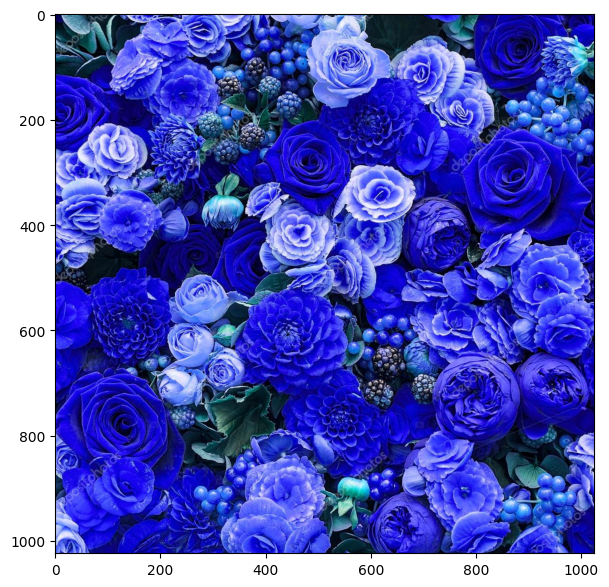

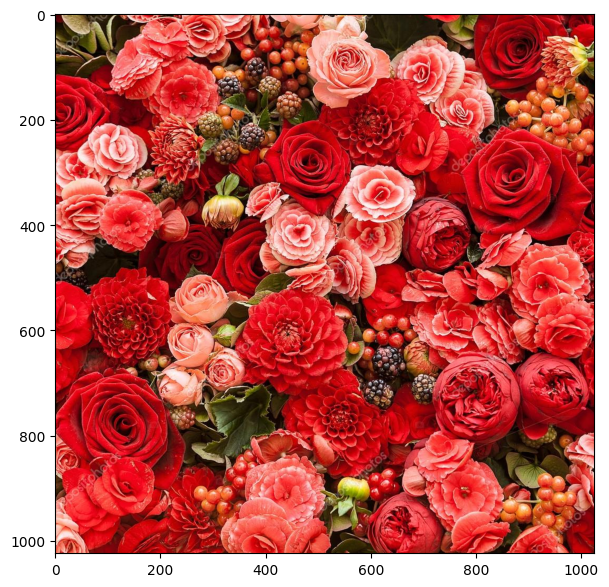

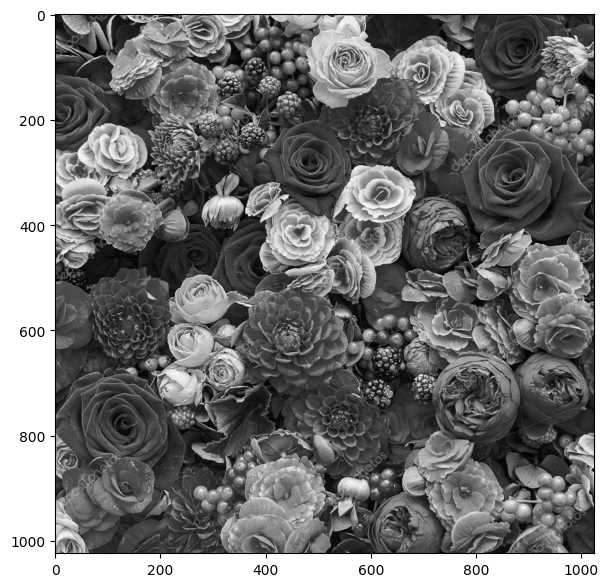

In [ ]:
show_img([x,x2])
plt_show(x3, cmap='gray')

In [ ]:
# Get the height and width of an image.

get_hw(x)

(1024, 1024)

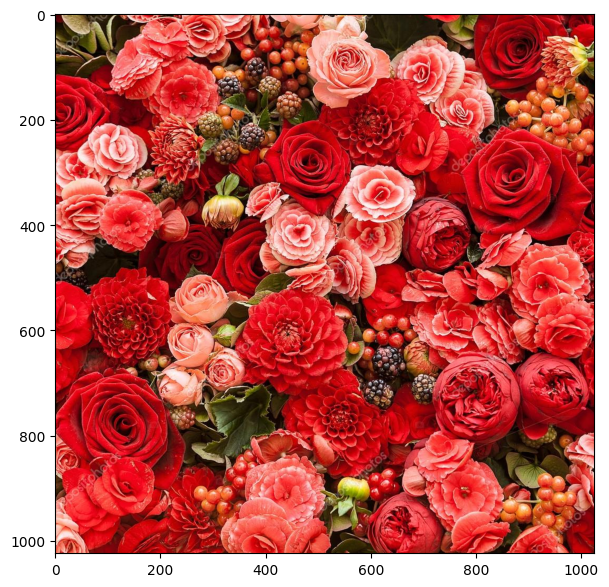

In [ ]:
plt_show(bgr2rgb(x))

Test if x is the same as x2 after converting from bgr to rgb.

In [ ]:
test_eq(bgr2rgb(x), x2)

Paste an image on a another image.

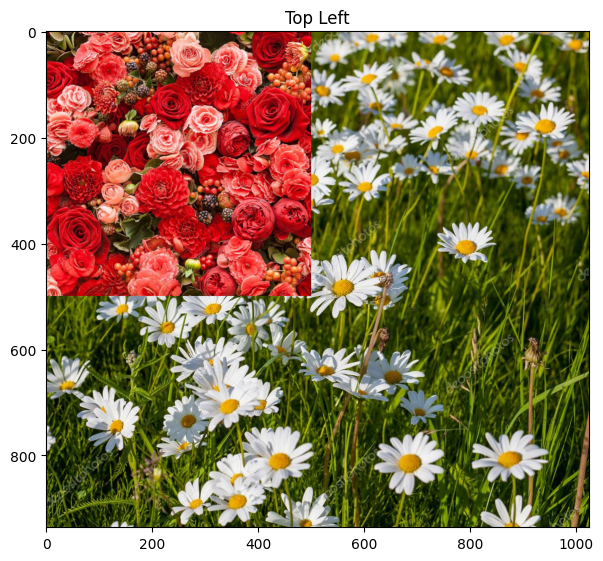

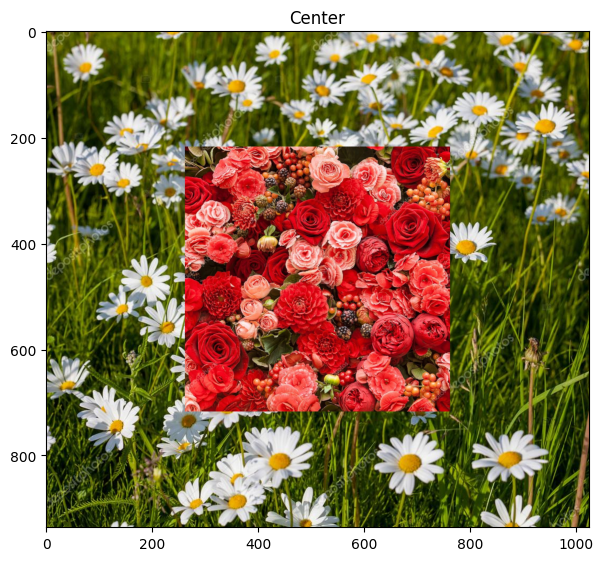

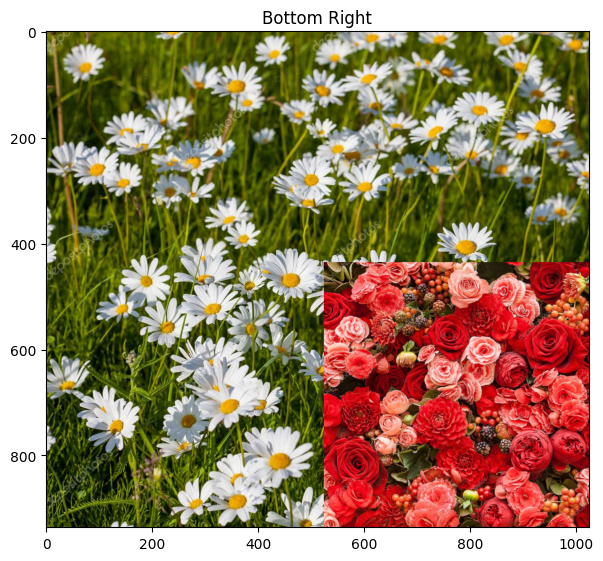

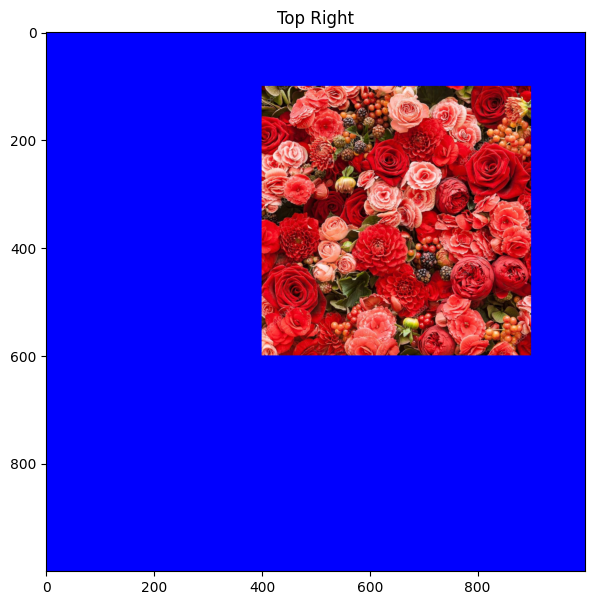

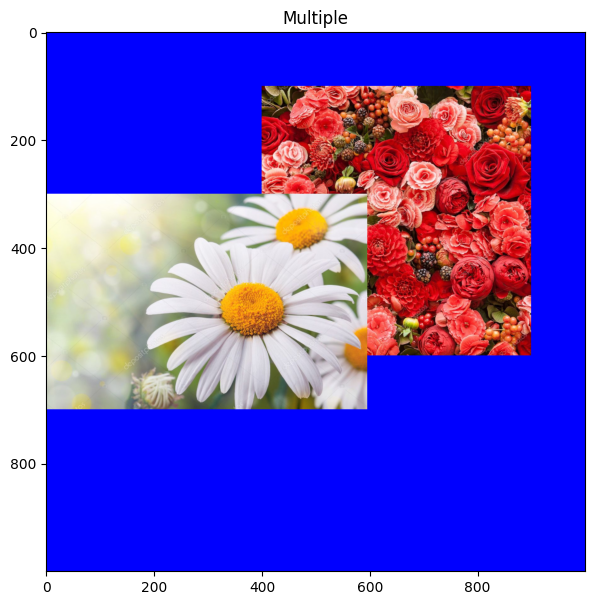

In [ ]:
bg = rgb_read(imgs[1])

# Resize x2 to 500 pixels wide. The height will be adjusted automatically.
x3 = resize_img(x2, width=500) 

# Paste x3 on bg at the top left corner.
img0 = paste_img(x3, bg, pos=(0,0))

# Paste x3 on bg at at the center.
img1 = paste_img(x3, bg, pos=('center','center')) # Can also be (0.5,0.5)

# Paste x3 on bg at at the bottom right corner.
img2 = paste_img(x3, bg, pos=(1.,1.)) # 1. means 100% of the width and height because we are using relative coordinates.

# Creating our own background.
bg2 = solid_color_img((1000,1000,3), color='blue')

# Paste x3 on bg2 with a 20% gap from the right and 100 pixels down. Position can be both relative and absolute.
img3 = paste_img(x3, bg2, pos=(0.8,100))

# Paste another image on img3.
x4 = resize_img(rgb_read(imgs[2]), height=400)
img4 = paste_img(x4, img3, pos=(0,0.5))

plt_show(img0, title='Top Left')
plt_show(img1, title='Center')
plt_show(img2, title='Bottom Right')
plt_show(img3, title='Top Right')
plt_show(img4, title='Multiple')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()